# You can check Table of Contents to see contents headings

# Download Dataset from Kaggle

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')
# upload "kaggle.json" to connect to Kaggle with Kaggle APIs key
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Pull dataset from Kaggle
!kaggle datasets download -d erhmrai/ecg-image-data

100% 854M/858M [00:06<00:00, 137MB/s]
100% 858M/858M [00:06<00:00, 147MB/s]


In [ ]:
# Unzip
!unzip ecg-image-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECG_Image_data/train/V/V1869.png  
  inflating: ECG_Image_data/train/V/V187.png  
  inflating: ECG_Image_data/train/V/V1870.png  
  inflating: ECG_Image_data/train/V/V1871.png  
  inflating: ECG_Image_data/train/V/V1872.png  
  inflating: ECG_Image_data/train/V/V1874.png  
  inflating: ECG_Image_data/train/V/V1877.png  
  inflating: ECG_Image_data/train/V/V1879.png  
  inflating: ECG_Image_data/train/V/V188.png  
  inflating: ECG_Image_data/train/V/V1880.png  
  inflating: ECG_Image_data/train/V/V1881.png  
  inflating: ECG_Image_data/train/V/V1882.png  
  inflating: ECG_Image_data/train/V/V1883.png  
  inflating: ECG_Image_data/train/V/V1884.png  
  inflating: ECG_Image_data/train/V/V1885.png  
  inflating: ECG_Image_data/train/V/V1886.png  
  inflating: ECG_Image_data/train/V/V1887.png  
  inflating: ECG_Image_data/train/V/V1889.png  
  inflating: ECG_Image_data/train/V/V1892.png  
  inflating: ECG_Image_data/train/V/V18

# Import neccessary libraries

In [ ]:
from pathlib import Path
import urllib.request
import os
import zipfile
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import Image
from shutil import copyfile
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import numpy as np

Test GPU

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Creates a graph.
with tf.device('/device:GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

c

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[22., 28.],
       [49., 64.]], dtype=float32)>

# Explore the Dataset

In [ ]:
root = Path().cwd()/"ECG_Image_data"
classes = os.listdir(root/"train")
dataset_dir = os.listdir(root)

# function to create text report of the number of dataset
def report_dataset_size(dataset="train"):
  num_of_images = {c : 0 for c in classes}
  for c in classes:
    num_of_images[c] += len(os.listdir(root/dataset/c))

  print(f"Number of images in {dataset} dataset: \n", num_of_images)
  print("Total: ", sum(num_of_images.values()))
  return (num_of_images, dataset)

# function to vizualize the size of dataset
def visualize_dataset_size(num_of_images, dataset_name):
  plt.figure(figsize=(6,4))
  plt.grid()
  category = num_of_images.keys()
  value = num_of_images.values()
  plt.bar(category, value, width = 0.5)
  plt.xlabel('Category')
  plt.ylabel("Count")
  plt.title("Dataset Size of " + dataset_name)
  plt.show()

Number of images in test dataset: 
 {'S': 556, 'M': 2101, 'Q': 1608, 'F': 161, 'N': 18926, 'V': 1447}
Total:  24799


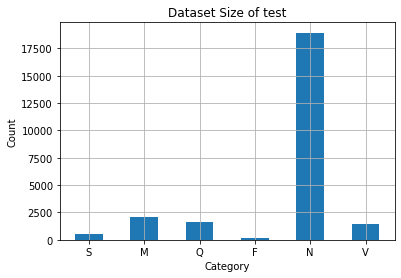

Number of images in train dataset: 
 {'S': 2223, 'M': 8405, 'Q': 6431, 'F': 642, 'N': 75709, 'V': 5789}
Total:  99199


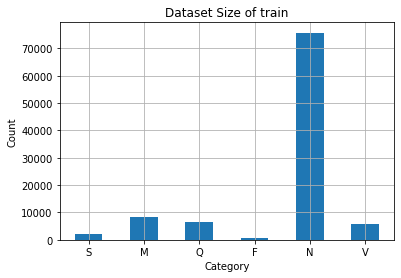

In [ ]:
for dataset in dataset_dir:
  report, dataset_name = report_dataset_size(dataset)
  visualize_dataset_size(report, dataset_name)

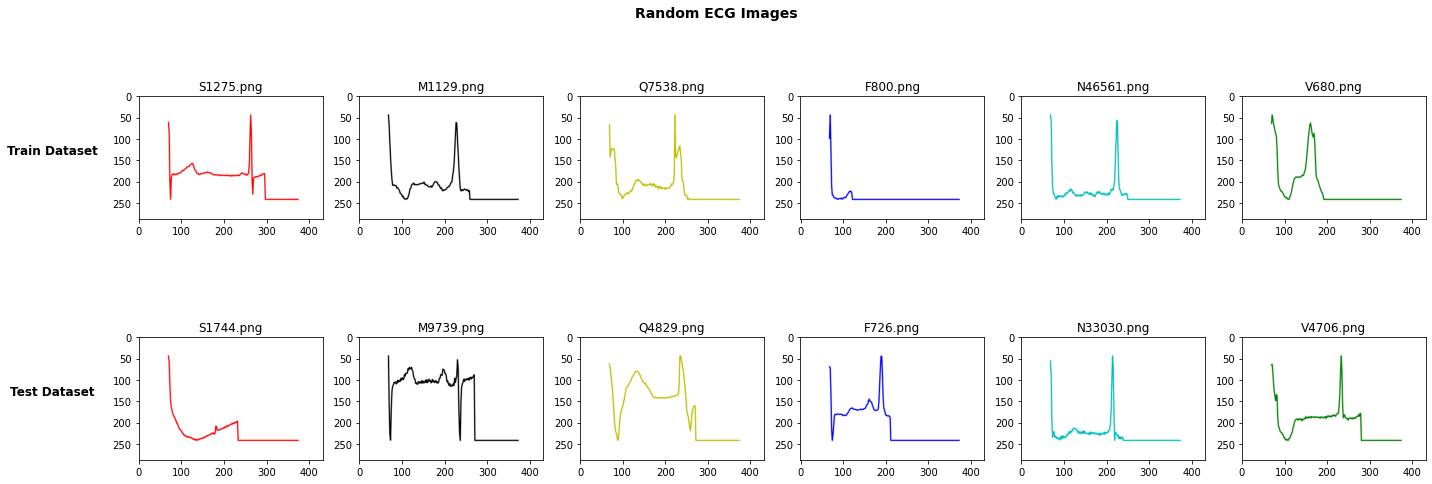

In [ ]:
# Visualize some images of each category
figure, axs = plt.subplots(nrows=2, ncols=6, figsize=(20,8))
for i, dataset in enumerate(dataset_dir):
  for j, c in enumerate(classes):
    image_file_name = random.choice(os.listdir(root/dataset/c))
    image = Image.open(f"./ECG_Image_data/{dataset}/{c}/" + image_file_name)
    axs[i, j].imshow(image)
    axs[i, j].set_title(image_file_name)
    axs[i, j].axis('image')

figure.suptitle("Random ECG Images", fontsize=14, fontweight='bold', y=0.95)
axs[0,0].set_ylabel("Train Dataset", fontsize=12, fontweight='bold', rotation=0, labelpad=60)
axs[1,0].set_ylabel("Test Dataset", fontsize=12, fontweight='bold', rotation=0, labelpad=60)

plt.tight_layout()
plt.show()

# Data preprocessing and preparation of data loader

According to the article "BAGAN: Data Augmentation with Balancing GAN" by Mariani et al (2018), BAGAN was developed to generate minority-class images.

> https://arxiv.org/abs/1803.09655

The proposed BAGAN methodology consists of three training steps: 

1. Pre-training of the autoencoder: The encoder module of an autoencoder is trained to learn an accurate class-conditioning in the latent space.

2. Adversarial training of the generator and discriminator: The generator is initialized with the encoder module of the pre-trained autoencoder, and then adversarially trained with a discriminator to generate high-quality images. During this process, we apply class conditioning in the latent space to drive the generation process towards a target class.

3. Fine-tuning of deep-learning classifiers: The augmented dataset generated by BAGAN is used to fine-tune deep-learning classifiers, resulting in higher accuracy compared to other generative adversarial networks when aiming at the generation of high-quality images starting with an imbalanced training set.

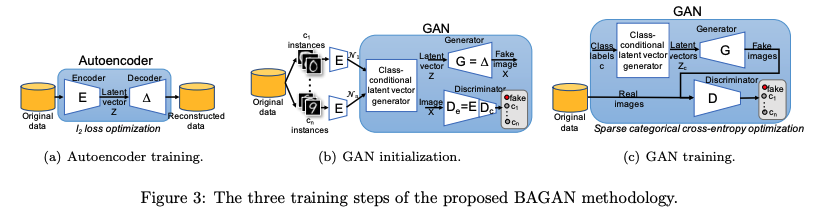




Later in 2021, Huang, G., Jafari, A.H. Enhanced balancing GAN: minority-class image generation. Neural Comput & Applic (2021). https://doi.org/10.1007/s00521-021-06163-8 published.

In this challenge, I'd like to refer to this article and their github repo: https://github.com/GH920/improved-bagan-gp

And, know-how from https://github.com/soumith/ganhacks



> My plan is to modify these models. The generator will take 
1.   Encoded image
2.   Label




### Prepare Batch Generator and Data preprocessing

In [ ]:
batch_size = 128

Note:
I have reduced 85% size of dataset, in order to demonstrate GAN.

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.85) 
test_datagen = ImageDataGenerator(validation_split=0.85) 

train_dir = root/"train"
test_dir = root/"test"

train_data = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64, 64),
                                                    color_mode='grayscale',
                                                    class_mode='sparse',
                                                    shuffle=True,
                                                    subset='training')

test_data = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(64, 64),
                                                  color_mode='grayscale',
                                                  class_mode='sparse',
                                                  shuffle=False,
                                                  subset='training')
classes = np.unique(train_data.classes)

per_class_count = [np.sum(np.array(train_data.classes == c)) for c in classes]

def prepare_dataset(data):
  dataset_x, dataset_y = [], []
  for i in range(len(data)):
      x, y = data[i]
      dataset_x.append(x)
      dataset_y.append(y)

  # Normalize between -1 and 1
  dataset_x = (np.concatenate(dataset_x) - 127.5) / 127.5
  dataset_y = np.concatenate(dataset_y)

  return dataset_x, dataset_y

Found 14883 images belonging to 6 classes.
Found 3724 images belonging to 6 classes.


In [ ]:
x_train, y_train = prepare_dataset(train_data)
print(x_train.shape)
print(y_train.shape)

(14883, 64, 64, 1)
(14883,)


In [ ]:
x_test, y_test = prepare_dataset(test_data)
print(x_test.shape)
print(y_test.shape)

(3724, 64, 64, 1)
(3724,)


In [ ]:
print(y_train[:10])
print(y_test[:10])

[2. 2. 2. 2. 5. 5. 2. 1. 2. 2.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(classes)
print(per_class_count)

[0 1 2 3 4 5]
[97, 1261, 11357, 965, 334, 869]


# Prepare models
refer to the article

In [ ]:
import os
import random
import cv2
from tensorflow.keras import Model, Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, \
    Activation, LeakyReLU, Conv2D, Conv2DTranspose, Embedding, \
    Concatenate, multiply, Flatten, BatchNormalization
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.optimizers import Adam

In [ ]:
# Get image size
img_size = x_train[0].shape
# Get number of classes
n_classes = len(classes)

print(img_size)
print(n_classes)

(64, 64, 1)
6


Hyperparameters

In [ ]:
# Seed
seed = 99
random.seed(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
weight_init = glorot_normal(seed=seed)

optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
latent_dim=128
trainRatio = 5
channel = x_train[0].shape[-1]

In [ ]:
# Viz model
def viz_model(model):
  return tf.keras.utils.plot_model(model, 
                            show_shapes=True, 
                            show_layer_activations=True, 
                            show_dtype=True,
                            show_layer_names=True )

### Encoder
refer to the article

In [ ]:
# Build Encoder
def encoder():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    img = Input(img_size)

    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(img)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    feature = Flatten()(x)

    feature = Dense(latent_dim)(feature)
    out = LeakyReLU(0.2)(feature)

    model = Model(inputs=img, outputs=out)
    return model

In [ ]:
enc = encoder()
enc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0     

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


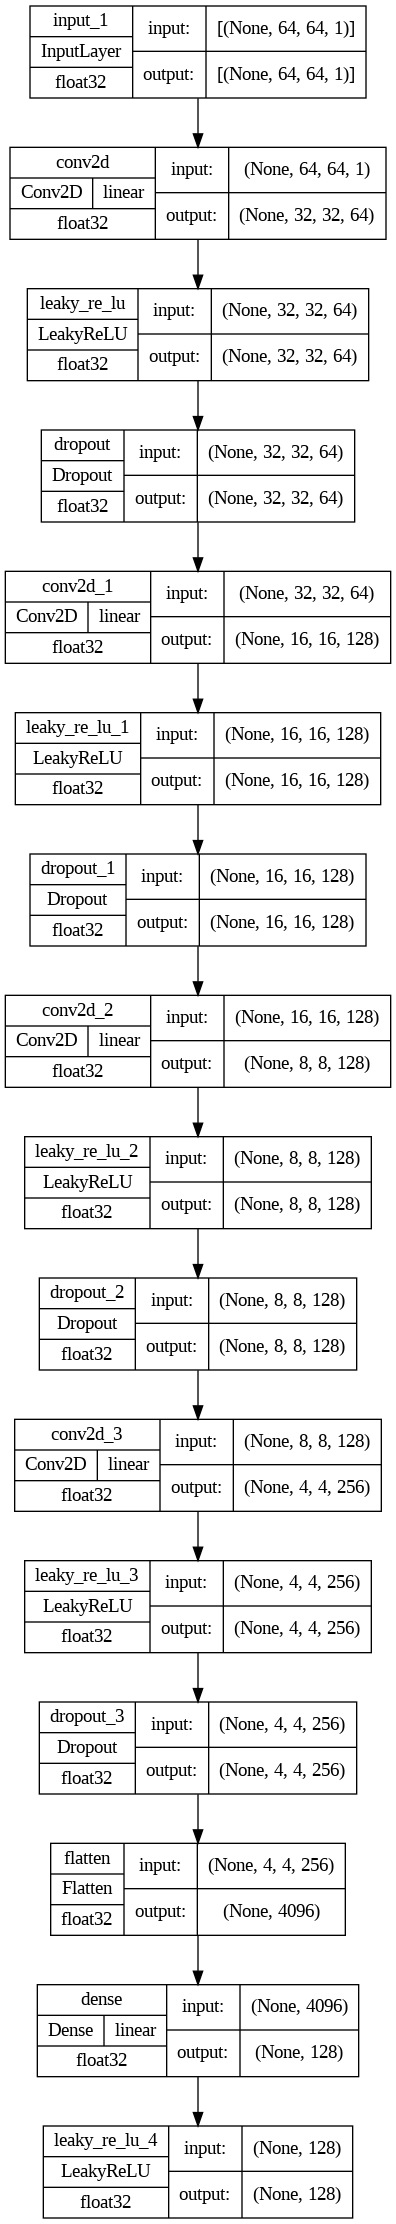

In [ ]:
viz_model(enc)

### Embedding
refer to the article

In [ ]:
# Build Embedding model
def embedding_labeled_latent():
    # # weight initialization
    init = RandomNormal(stddev=0.02)

    label = Input((1,), dtype='int32')
    noise = Input((latent_dim,))

    le = Flatten()(Embedding(n_classes, latent_dim)(label))
    # le = Dense(256)(le)
    # le = LeakyReLU(0.2)(le)

    noise_le = multiply([noise, le])
    # noise_le = Dense(latent_dim)(noise_le)

    model = Model([noise, label], noise_le)

    return model

In [ ]:
embed = embedding_labeled_latent()

In [ ]:
embed.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       768         ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 128)          0           ['embedding[0][0]']              
                                                                                            

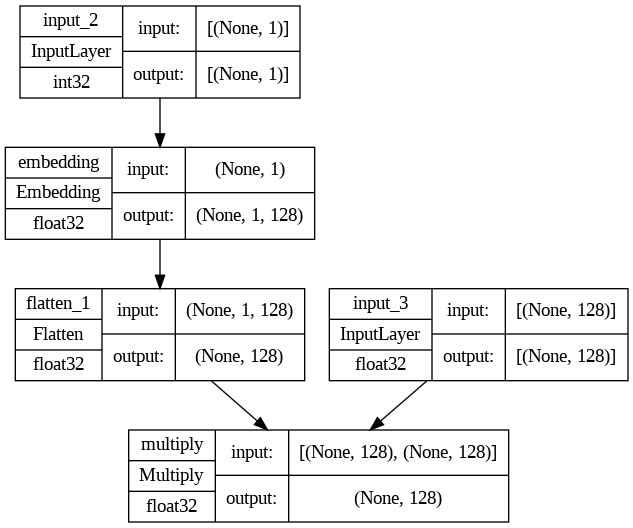

In [ ]:
viz_model(embed)

### Decoder

In [ ]:
# Build Generator/Decoder
def decoder():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    noise_le = Input((latent_dim,))

    x = Dense(4*4*256)(noise_le)
    x = LeakyReLU(alpha=0.2)(x)

    ## Size: 4 x 4 x 256
    x = Reshape((4, 4, 256))(x)

    ## Size: 8 x 8 x 128
    x = Conv2DTranspose(filters=128,
                        kernel_size=(4, 4),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 16 x 16 x 128
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 32 x 32 x 64
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 64 x 64 x 3
    generated = Conv2DTranspose(channel, (4, 4), strides=(2, 2), padding='same', activation='tanh', kernel_initializer=init)(x)


    generator = Model(inputs=noise_le, outputs=generated)
    return generator

In [ ]:
dec = decoder()
dec.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              528384    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                             

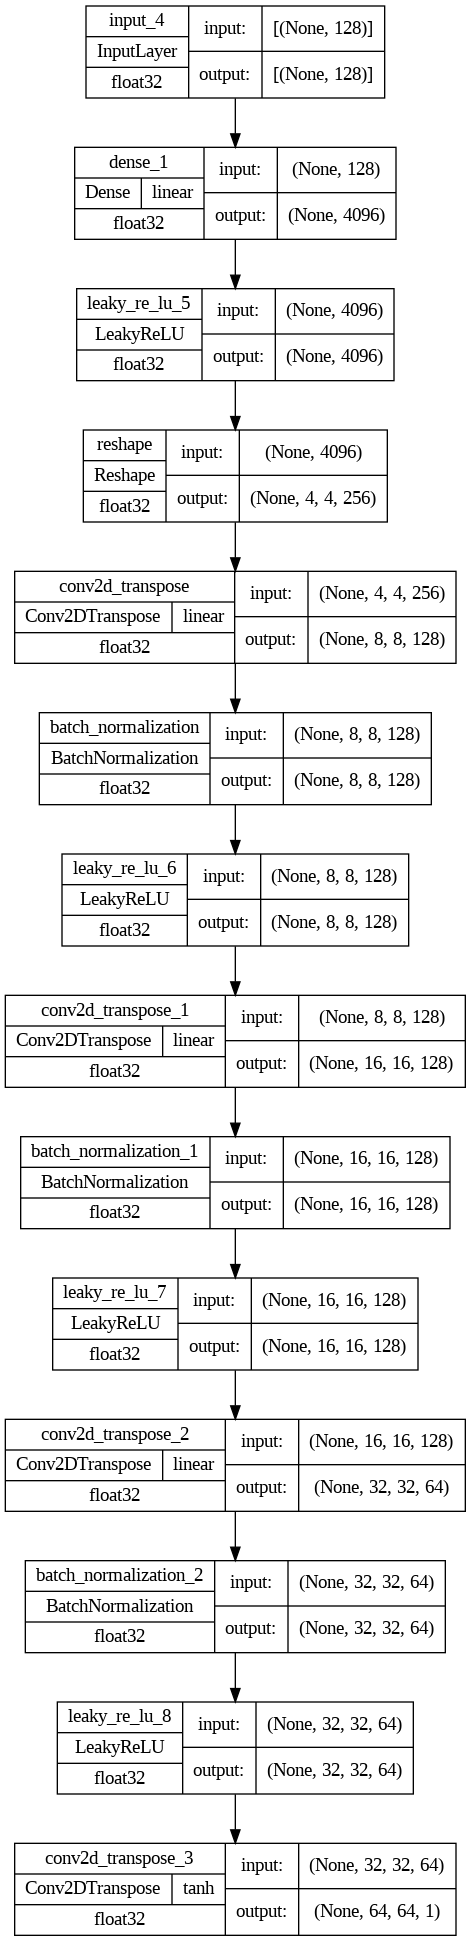

In [ ]:
viz_model(dec)

### Prepare GAN Architecture

#### Discriminator
refer to the article

In [ ]:
def discriminator_cwgan():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    img = Input(img_size)
    label = Input((1,), dtype='int32')


    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(img)
    # x = LayerNormalization()(x) # It is not suggested to use BN in Discriminator of WGAN
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)

    le = Flatten()(Embedding(n_classes, 512)(label))
    le = Dense(4 * 4 * 256)(le)
    le = LeakyReLU(0.2)(le)
    x_y = multiply([x, le])
    x_y = Dense(512)(x_y)

    out = Dense(1)(x_y)

    model = Model(inputs=[img, label], outputs=out)

    return model

In [ ]:
disc = discriminator_cwgan()
disc.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 64)   1088        ['input_5[0][0]']                
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 32, 32, 64)   0           ['conv2d_4[0][0]']               
                                                                                                  
 dropout_4 (Dropout)            (None, 32, 32, 64)   0           ['leaky_re_lu_9[0][0]']          
                                                                                            

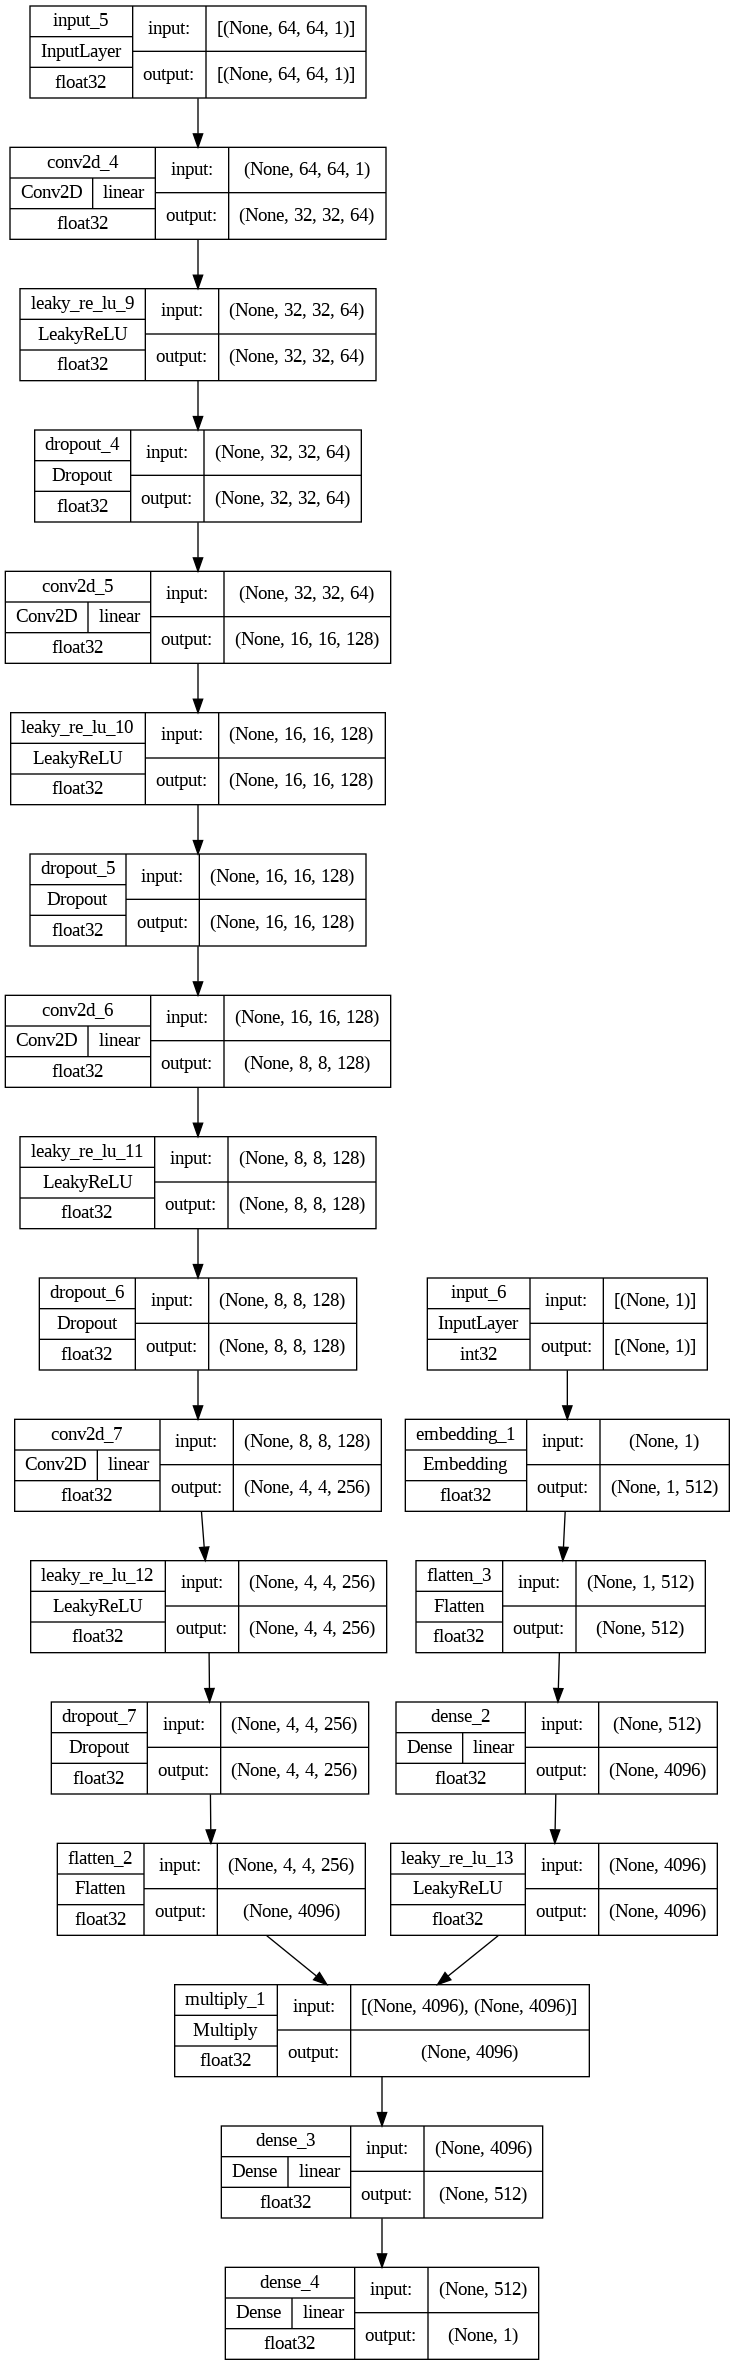

In [ ]:
viz_model(disc)

#### Generator
refer to the article

In [ ]:
# build generator
def generator_label(embedding, decoder):
    label = Input((1,), dtype='int32')
    latent = Input((latent_dim,))

    labeled_latent = embedding([latent, label])

    gen_img = decoder(labeled_latent)
    model = Model([latent, label], gen_img)

    return model

In [ ]:
gen = generator_label(embed, dec)
gen.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_1 (Functional)           (None, 128)          768         ['input_12[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 model_2 (Functional)           (None, 64, 64, 1)    1448513     ['model_1[1][0]']          

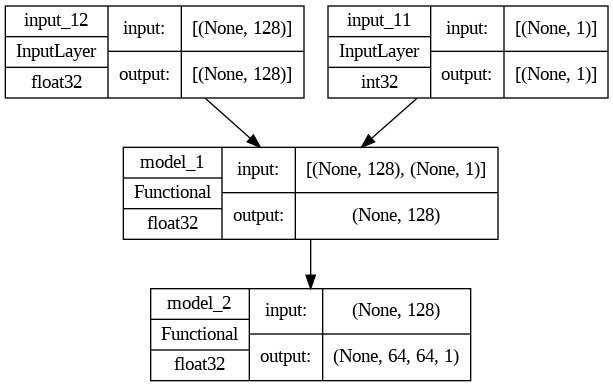

In [ ]:
viz_model(gen)

#### BAGAN-GP model
refer to the article

In [ ]:
class BAGAN_GP(Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(BAGAN_GP, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.train_ratio = trainRatio
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(BAGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        """ Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator([interpolated, labels], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        if isinstance(data, tuple):
            real_images = data[0]
            labels = data[1]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        ########################### Train the Discriminator ###########################
        # For each batch, we are going to perform cwgan-like process
        for i in range(self.train_ratio):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            fake_labels = tf.random.uniform((batch_size,), 0, n_classes)
            wrong_labels = tf.random.uniform((batch_size,), 0, n_classes)
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator([random_latent_vectors, fake_labels], training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator([fake_images, fake_labels], training=True)
                # Get the logits for real images
                real_logits = self.discriminator([real_images, labels], training=True)
                # Get the logits for wrong label classification
                wrong_label_logits = self.discriminator([real_images, wrong_labels], training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_logits=real_logits, fake_logits=fake_logits,
                                        wrong_label_logits=wrong_label_logits
                                        )

                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images, labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        ########################### Train the Generator ###########################
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_labels = tf.random.uniform((batch_size,), 0, n_classes)
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator([random_latent_vectors, fake_labels], training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator([generated_images, fake_labels], training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


Optimizer for both the networks

In [ ]:
# learning_rate=0.0002, beta_1=0.5, beta_2=0.9 are recommended
generator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

Refer to the DRAGAN loss function. https://github.com/kodalinaveen3/DRAGAN

In [ ]:
# Define the loss functions to be used for discrimiator
def discriminator_loss(real_logits, fake_logits, wrong_label_logits):
    real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)))
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    wrong_label_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=wrong_label_logits, labels=tf.zeros_like(fake_logits)))

    return wrong_label_loss + fake_loss + real_loss

# Define the loss functions to be used for generator
def generator_loss(fake_logits):
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    return fake_loss

# Compile BAGAN

In [ ]:
d_model = discriminator_cwgan()  # without initialization
g_model = generator_label(embed, dec)  # initialized with Decoder and Embedding

bagan_gp = BAGAN_GP(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_dim,
    discriminator_extra_steps=3,
)

# Compile the model
bagan_gp.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Train Model

Provided codes from the article for visualization training process

In [ ]:
# Plot/save generated images through training
def plt_img(generator, epoch):
    np.random.seed(42)
    latent_gen = np.random.normal(size=(n_classes, latent_dim))

    x_real = x_test * 0.5 + 0.5
    n = n_classes

    plt.figure(figsize=(2*n, 2*(n+1)))
    for i in range(n):
        # display original
        ax = plt.subplot(n+1, n, i + 1)
        if channel == 3:
            plt.imshow(x_real[y_test==i][4].reshape(64, 64, channel))
        else:
            plt.imshow(x_real[y_test == i][4].reshape(64, 64))
            plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for c in range(n):
            decoded_imgs = generator.predict([latent_gen, np.ones(n)*c])
            decoded_imgs = decoded_imgs * 0.5 + 0.5
            # display generation
            ax = plt.subplot(n+1, n, (i+1)*n + 1 + c)
            if channel == 3:
                plt.imshow(decoded_imgs[i].reshape(64, 64, channel))
            else:
                plt.imshow(decoded_imgs[i].reshape(64, 64))
                plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.savefig('bagan_gp_results/generated_plot_%d.png' % epoch)
    plt.show()
    return

# make directory to store results
os.system('mkdir -p bagan_gp_results')

0

### Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Record the loss
d_loss_history = []
g_loss_history = []

LEARNING STEP #  1 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 1.4973 - g_loss: 4.0726

117/117 [==============================] - 106s 689ms/step - d_loss: 1.4973 - g_loss: 4.0544
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.9773 - g_loss: 3.1049

1/1 [==============================] - 0s 20ms/step


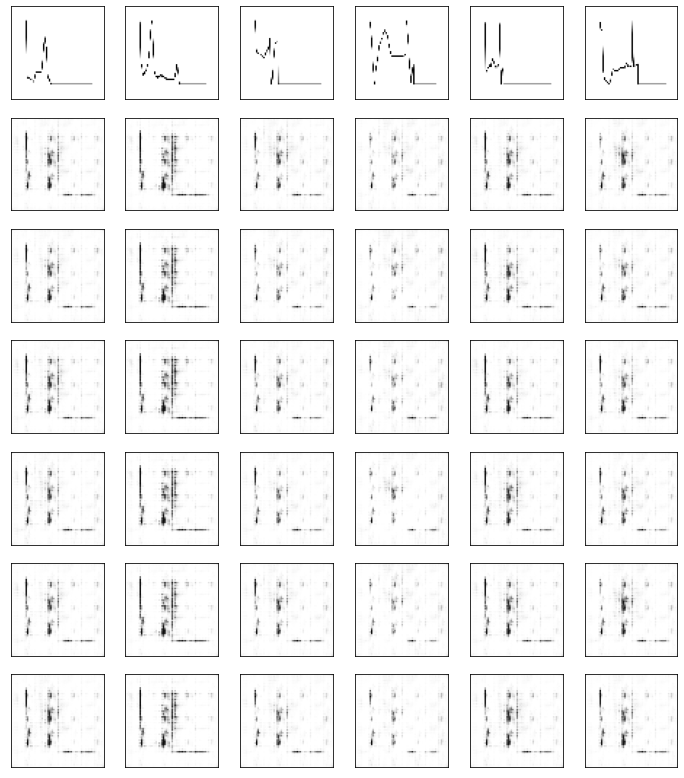

LEARNING STEP #  2 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8645 - g_loss: 3.4840

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8651 - g_loss: 3.4899
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8577 - g_loss: 3.4048

1/1 [==============================] - 0s 20ms/step


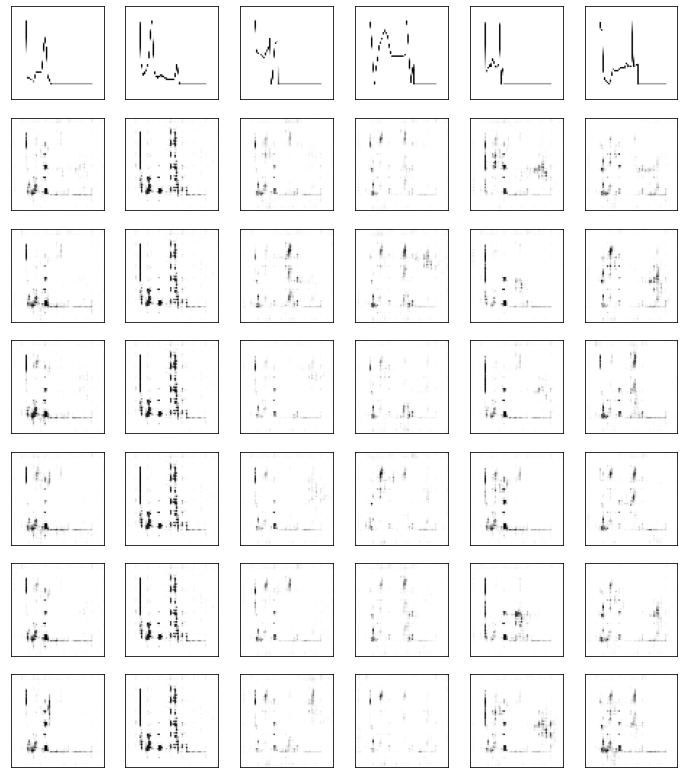

LEARNING STEP #  3 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8478 - g_loss: 3.3546

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8469 - g_loss: 3.3496
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8764 - g_loss: 3.2230

1/1 [==============================] - 0s 20ms/step


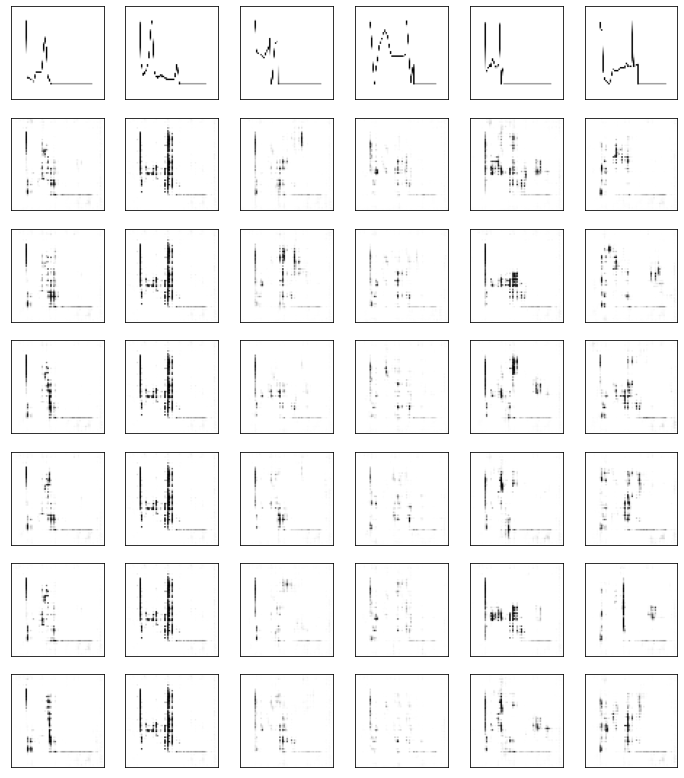

LEARNING STEP #  4 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8714 - g_loss: 3.1439

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8710 - g_loss: 3.1438
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8699 - g_loss: 3.0934

1/1 [==============================] - 0s 22ms/step


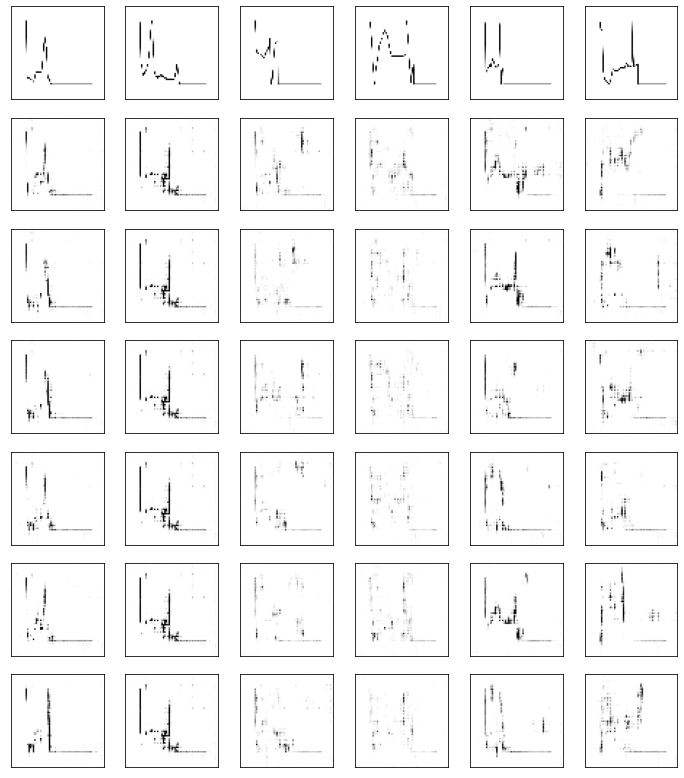

LEARNING STEP #  5 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8829 - g_loss: 2.9431

117/117 [==============================] - 82s 702ms/step - d_loss: 0.8836 - g_loss: 2.9437
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8731 - g_loss: 2.9811

1/1 [==============================] - 0s 19ms/step


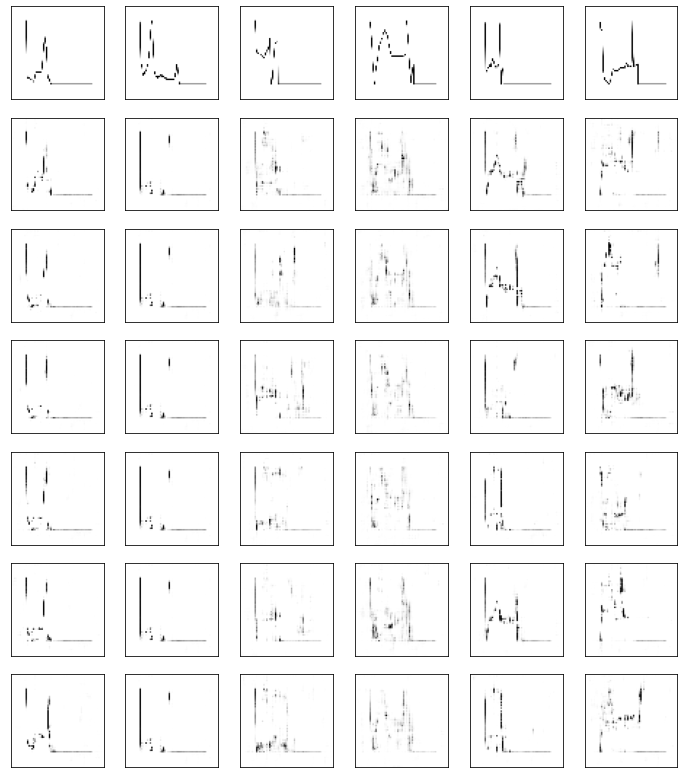

LEARNING STEP #  6 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8766 - g_loss: 2.9040

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8763 - g_loss: 2.9056
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8638 - g_loss: 2.9173

1/1 [==============================] - 0s 23ms/step


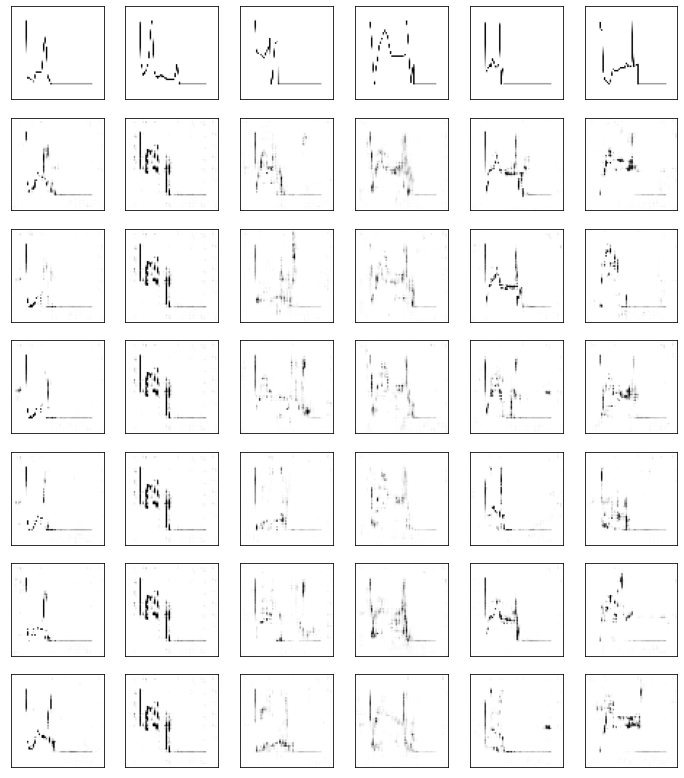

LEARNING STEP #  7 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8612 - g_loss: 2.8809

117/117 [==============================] - 82s 703ms/step - d_loss: 0.8622 - g_loss: 2.8816
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8759 - g_loss: 2.9164

1/1 [==============================] - 0s 20ms/step


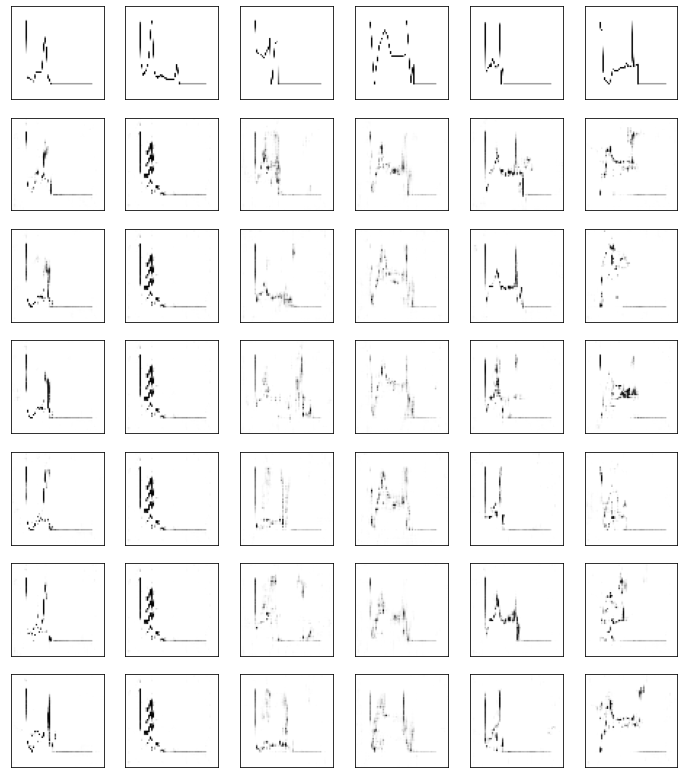

LEARNING STEP #  8 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8685 - g_loss: 2.8094

117/117 [==============================] - 82s 705ms/step - d_loss: 0.8688 - g_loss: 2.8124
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8737 - g_loss: 2.8114

1/1 [==============================] - 0s 28ms/step


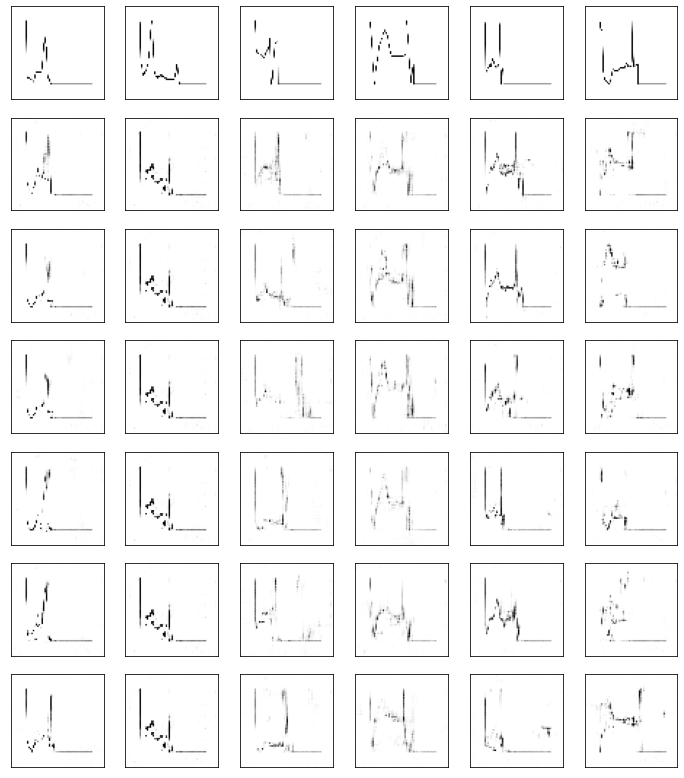

LEARNING STEP #  9 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8825 - g_loss: 2.7882

117/117 [==============================] - 82s 702ms/step - d_loss: 0.8805 - g_loss: 2.7837
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8886 - g_loss: 2.7860

1/1 [==============================] - 0s 22ms/step


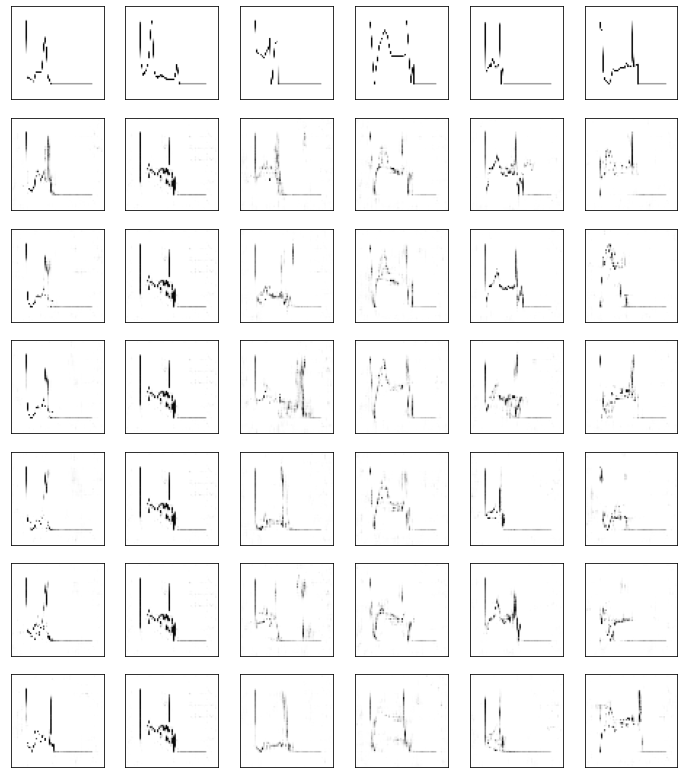

LEARNING STEP #  10 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8828 - g_loss: 2.7827

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8815 - g_loss: 2.7810
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8973 - g_loss: 2.7913

1/1 [==============================] - 0s 28ms/step


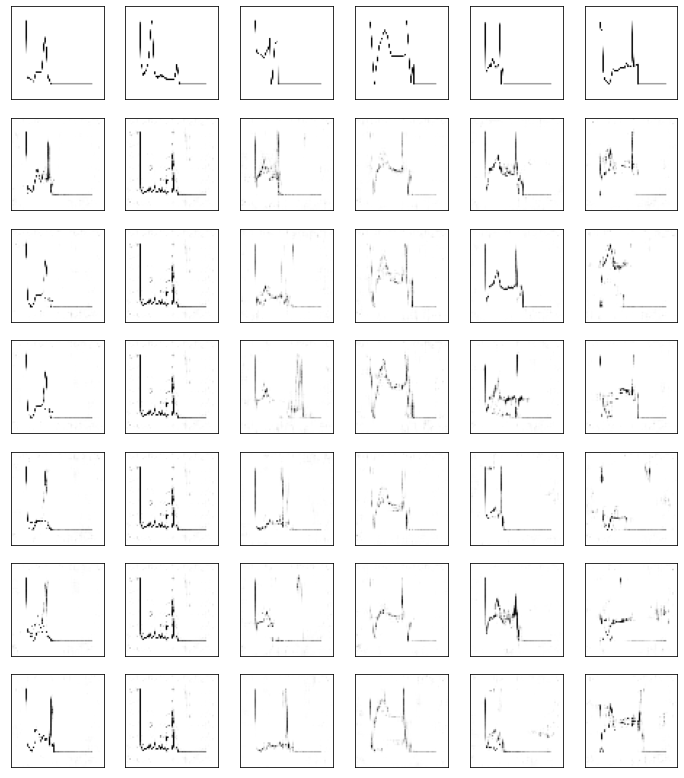

LEARNING STEP #  11 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8868 - g_loss: 2.7291

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8869 - g_loss: 2.7298
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8816 - g_loss: 2.7376

1/1 [==============================] - 0s 22ms/step


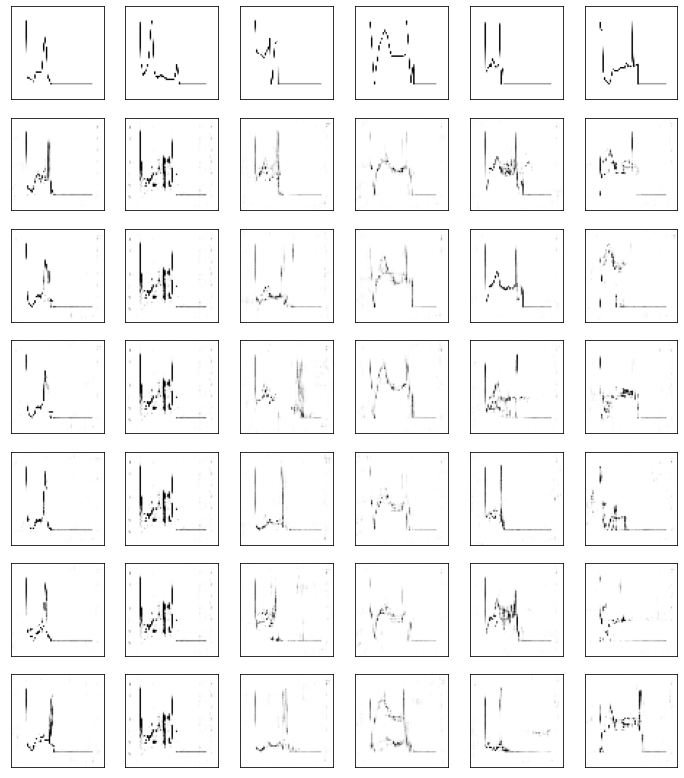

LEARNING STEP #  12 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8802 - g_loss: 2.7232

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8801 - g_loss: 2.7262
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8963 - g_loss: 2.7577

1/1 [==============================] - 0s 30ms/step


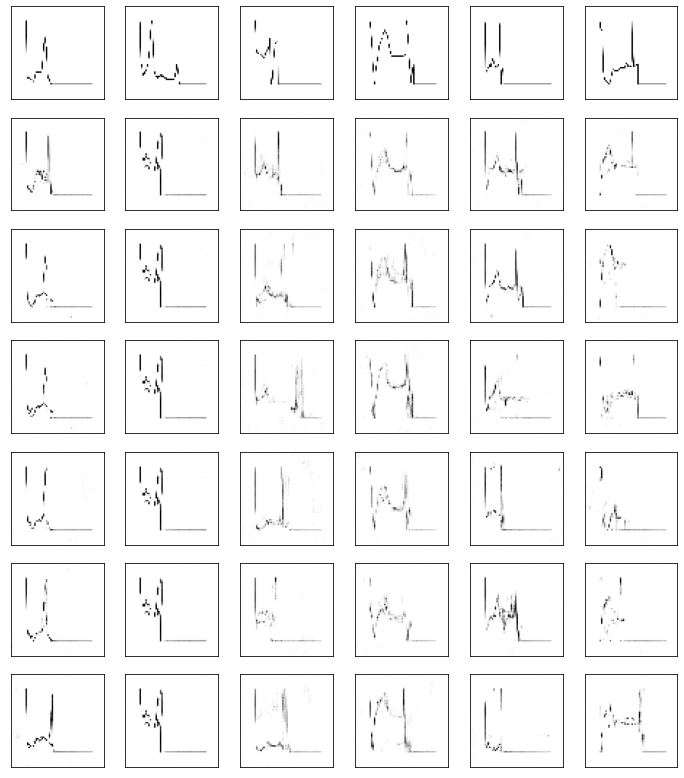

LEARNING STEP #  13 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8838 - g_loss: 2.7222

117/117 [==============================] - 82s 702ms/step - d_loss: 0.8833 - g_loss: 2.7283
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8885 - g_loss: 2.6908

1/1 [==============================] - 0s 19ms/step


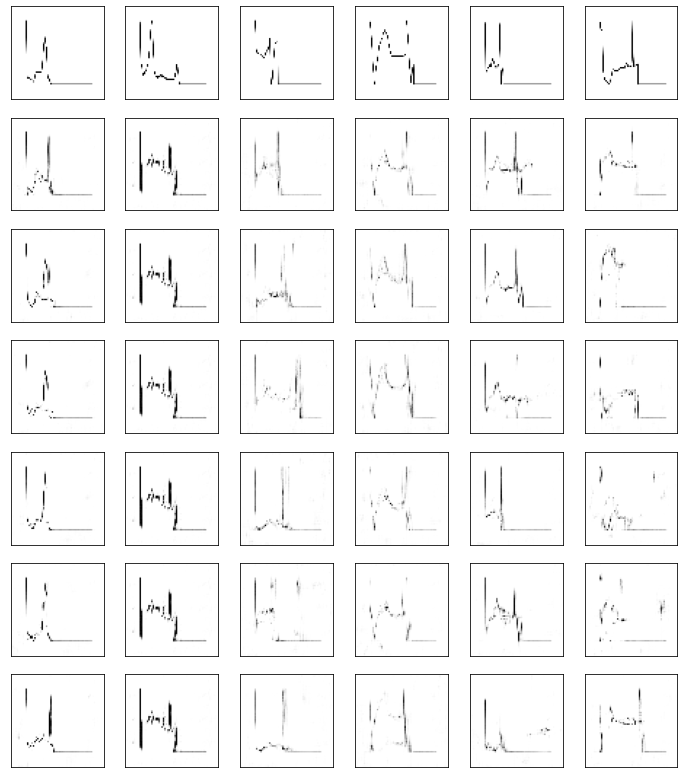

LEARNING STEP #  14 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8885 - g_loss: 2.7354

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8883 - g_loss: 2.7388
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8888 - g_loss: 2.7526

1/1 [==============================] - 0s 46ms/step


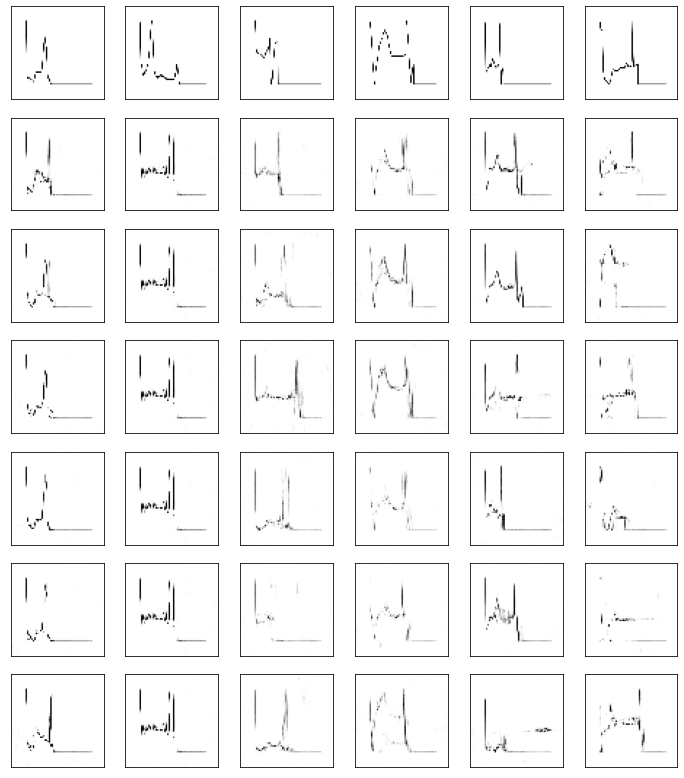

LEARNING STEP #  15 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8929 - g_loss: 2.6978

117/117 [==============================] - 83s 705ms/step - d_loss: 0.8931 - g_loss: 2.7019
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8925 - g_loss: 2.6814

1/1 [==============================] - 0s 24ms/step


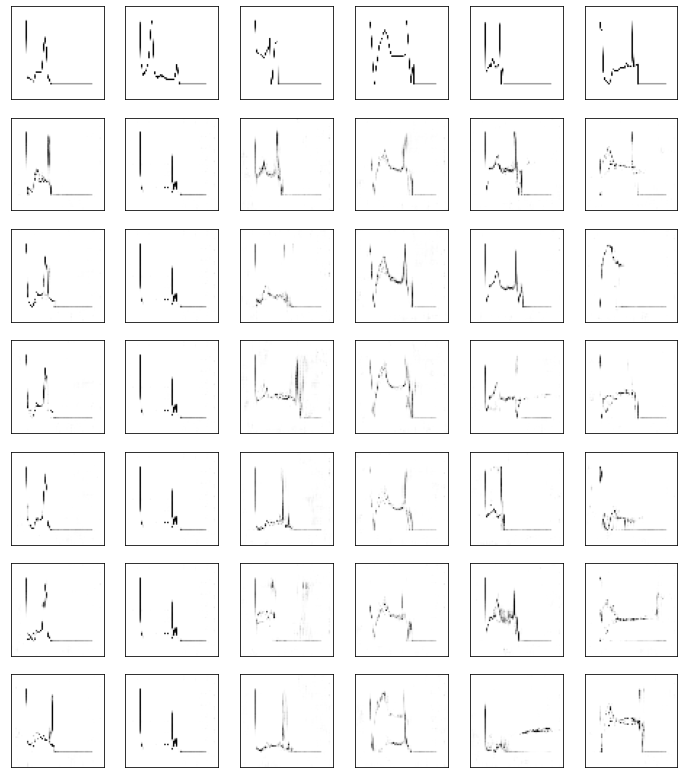

LEARNING STEP #  16 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.9011 - g_loss: 2.6656

117/117 [==============================] - 82s 704ms/step - d_loss: 0.9008 - g_loss: 2.6729
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8920 - g_loss: 2.6676

1/1 [==============================] - 0s 33ms/step


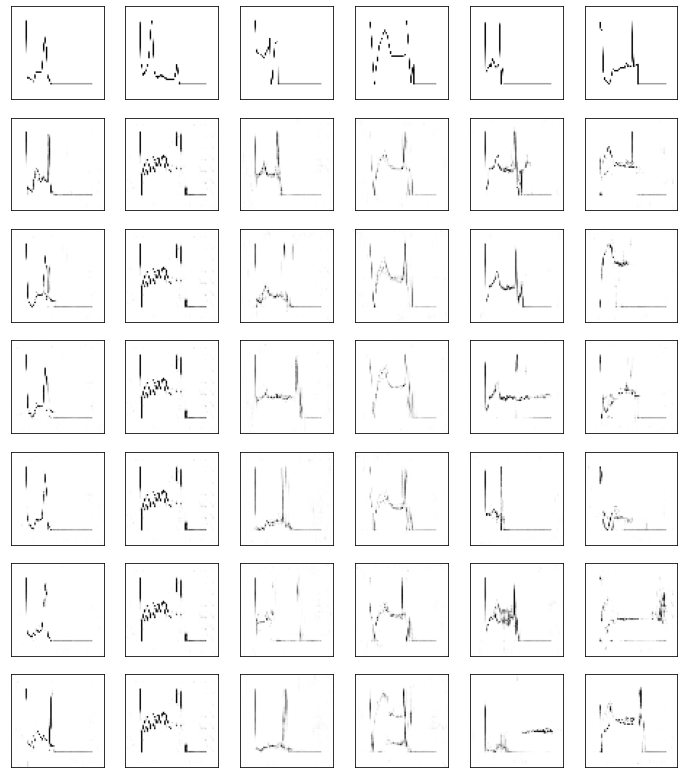

LEARNING STEP #  17 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.9049 - g_loss: 2.6726

117/117 [==============================] - 83s 705ms/step - d_loss: 0.9043 - g_loss: 2.6798
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8931 - g_loss: 2.6888

1/1 [==============================] - 0s 24ms/step


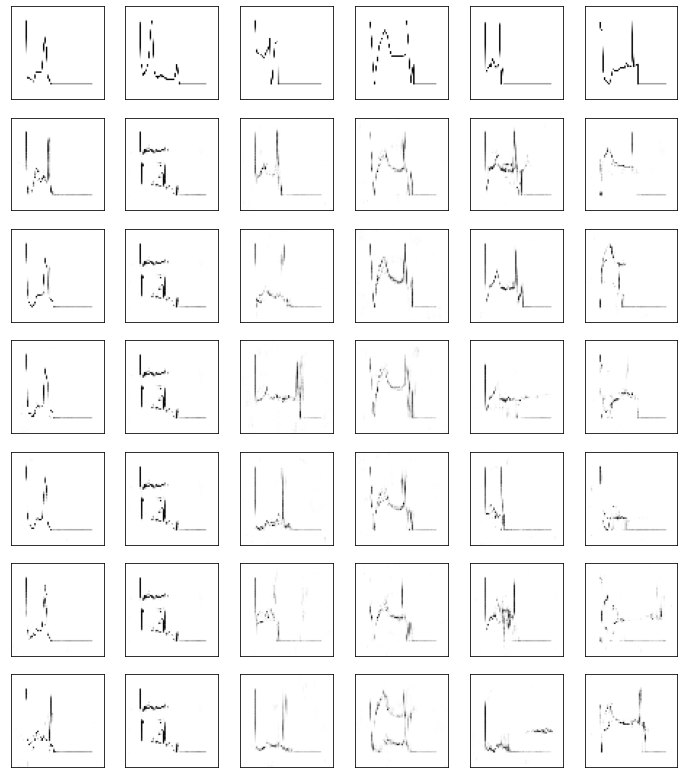

LEARNING STEP #  18 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.9009 - g_loss: 2.6926

117/117 [==============================] - 83s 705ms/step - d_loss: 0.9003 - g_loss: 2.6949
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8932 - g_loss: 2.6471

1/1 [==============================] - 0s 38ms/step


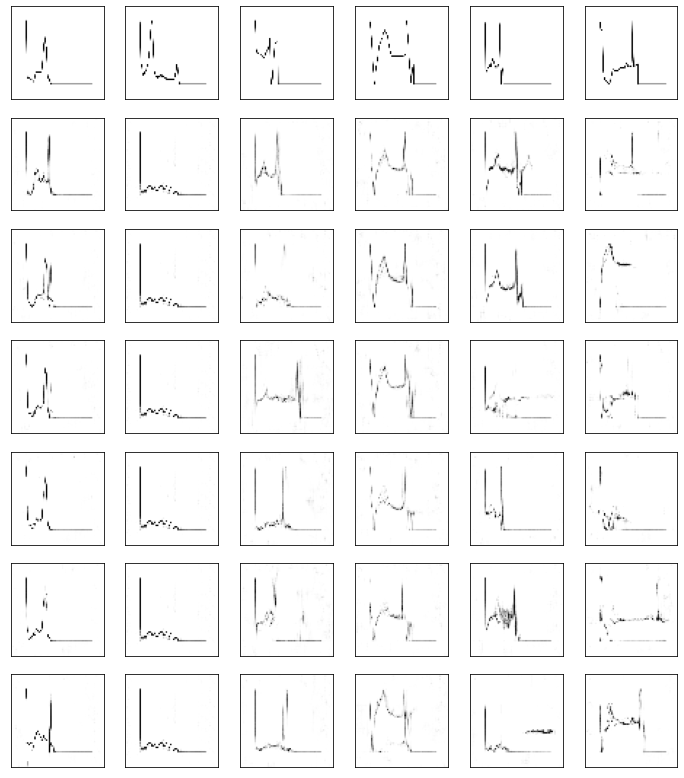

LEARNING STEP #  19 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8990 - g_loss: 2.6709

117/117 [==============================] - 83s 708ms/step - d_loss: 0.8987 - g_loss: 2.6700
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.9025 - g_loss: 2.6853

1/1 [==============================] - 0s 29ms/step


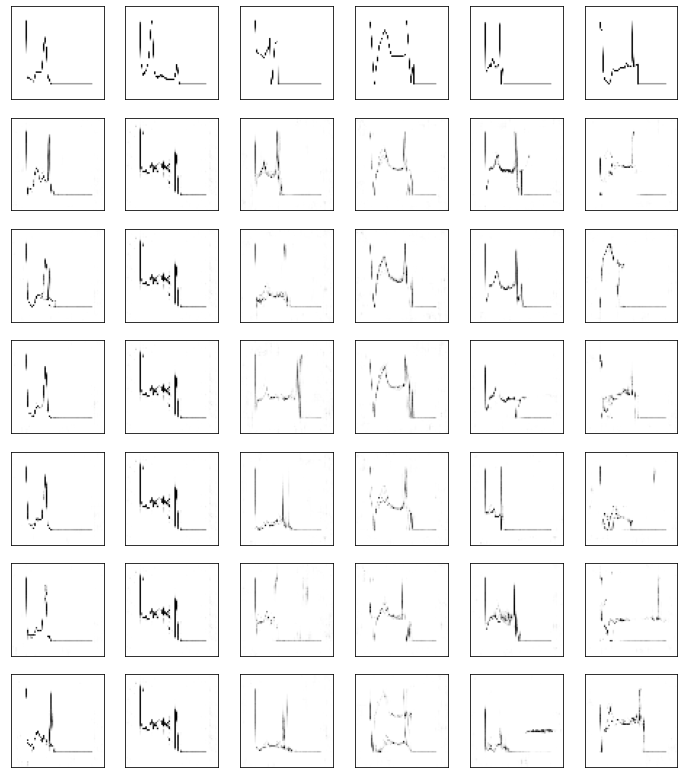

LEARNING STEP #  20 --------------------------------------------------
Epoch 1/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8997 - g_loss: 2.6354

117/117 [==============================] - 82s 702ms/step - d_loss: 0.8990 - g_loss: 2.6369
Epoch 2/2
117/117 [==============================] - ETA: 0s - d_loss: 0.8938 - g_loss: 2.7138

1/1 [==============================] - 0s 34ms/step


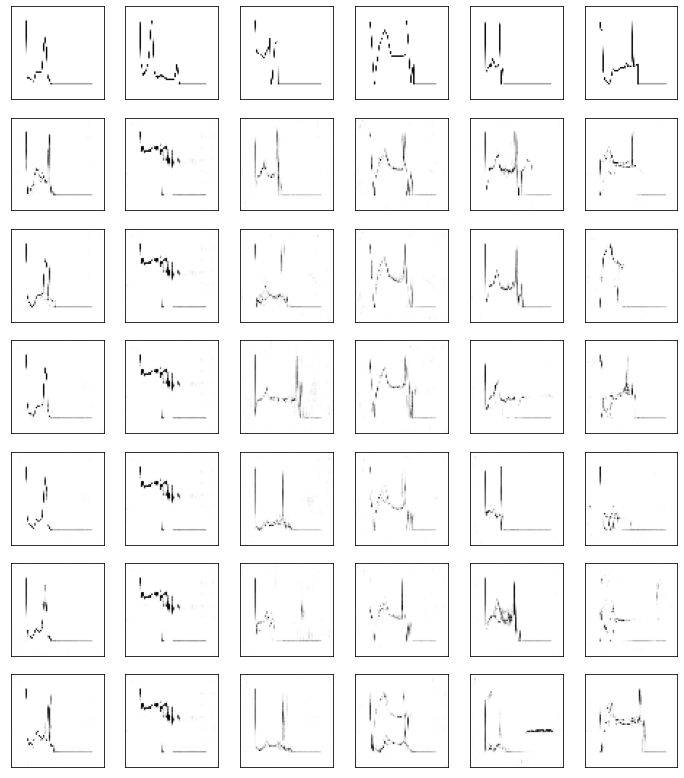

In [ ]:
LEARNING_STEPS = 20
with tf.device('/device:GPU:0'):
  for learning_step in range(LEARNING_STEPS):
      print('LEARNING STEP # ', learning_step + 1, '-' * 50)
      bagan_gp.fit(x_train, y_train, batch_size=128, epochs=2, callbacks=[early_stop])
      d_loss_history += bagan_gp.history.history['d_loss']
      g_loss_history += bagan_gp.history.history['g_loss']
      if (learning_step+1)%1 == 0:
          plt_img(bagan_gp.generator, learning_step)

### Performance Evaluation

In [ ]:
!zip -r /content/bagan_gp_results.zip /content/bagan_gp_results/

updating: content/bagan_gp_results/ (stored 0%)
  adding: content/bagan_gp_results/generated_plot_4.png (deflated 7%)
  adding: content/bagan_gp_results/generated_plot_5.png (deflated 6%)
  adding: content/bagan_gp_results/generated_plot_0.png (deflated 4%)
  adding: content/bagan_gp_results/generated_plot_14.png (deflated 7%)
  adding: content/bagan_gp_results/generated_plot_13.png (deflated 8%)
  adding: content/bagan_gp_results/generated_plot_8.png (deflated 6%)
  adding: content/bagan_gp_results/generated_plot_9.png (deflated 6%)
  adding: content/bagan_gp_results/generated_plot_12.png (deflated 7%)
  adding: content/bagan_gp_results/generated_plot_16.png (deflated 8%)
  adding: content/bagan_gp_results/generated_plot_7.png (deflated 7%)
  adding: content/bagan_gp_results/generated_plot_6.png (deflated 7%)
  adding: content/bagan_gp_results/generated_plot_10.png (deflated 7%)
  adding: content/bagan_gp_results/generated_plot_11.png (deflated 7%)
  adding: content/bagan_gp_results/g

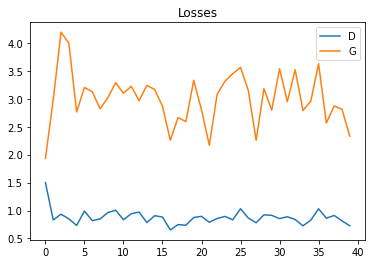

In [ ]:
# plot loss of G and D
plt.plot(d_loss_history, label='D')
plt.plot(g_loss_history, label='G')
plt.title("Losses")
plt.legend()
plt.savefig('ecg_loss_plot.png')
plt.show()

In [ ]:
# save gif
import imageio
ims = []
for i in range(LEARNING_STEPS):
    fname = 'generated_plot_%d.png' % i
    dir = 'bagan_gp_results/'
    if fname in os.listdir(dir):
        print('loading png...', i)
        im = imageio.imread(dir + fname, 'png')
        ims.append(im)
print('saving as gif...')
imageio.mimsave(dir + 'training_demo.gif', ims, fps=3)

loading png... 0
loading png... 1
loading png... 2
loading png... 3
loading png... 4
loading png... 5
loading png... 6
loading png... 7
loading png... 8
loading png... 9
loading png... 10
loading png... 11
loading png... 12
loading png... 13
loading png... 14
loading png... 15
loading png... 16
loading png... 17
loading png... 18
loading png... 19
saving as gif...


Illustration of each iterations

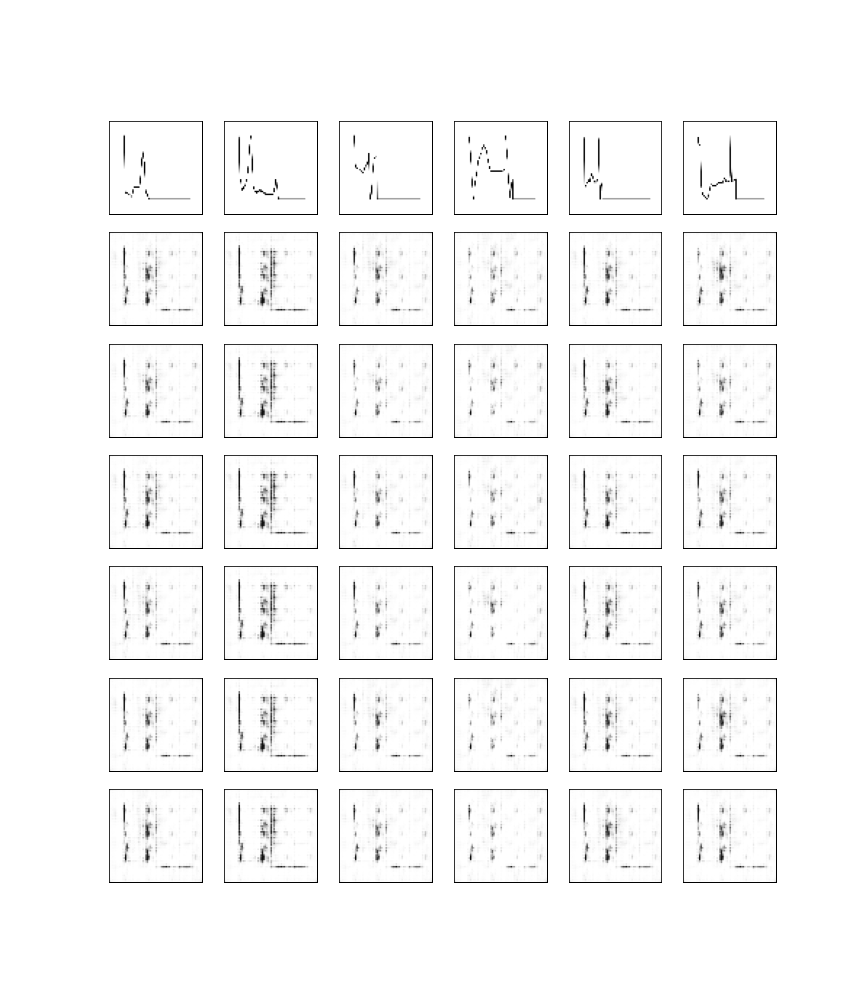

In [ ]:
# Save the model
generator_path = "ECG_generator.h5"
bagan_gp.generator.save(generator_path)

encoder_path = "ECG_encoder.h5"
enc.save(encoder_path)

embed_path = "ECG_embed.h5"
embed.save(embed_path)

# Test generate an image

In [ ]:
from tensorflow.keras.models import load_model
loaded_generator = load_model("ECG_generator.h5")
loaded_encoder = load_model("ECG_encoder.h5")

In [ ]:
# prepare for mapping
num_to_class_dict = {
    0: "F",
    1: "M",
    2: "N",
    3: "Q",
    4: "S",
    5: "V"
}

class_to_num_dict = {
    "F": 0.0,
    "M": 1.0,
    "N": 2.0,
    "Q": 3.0,
    "S": 4.0,
    "V": 5.0
}

In [ ]:
def generate_and_plot_ecg(x_test, y_test, num_of_img_in_batch):
  latent = loaded_encoder.predict(x_test)
  predict = loaded_generator.predict([latent, y_test])

  img = predict[num_of_img_in_batch]
  img = tf.image.resize(img, size=(100, 250), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  label_to_show = y_test[num_of_img_in_batch]
  label_plot = num_to_class_dict[int(label_to_show)]

  plt.title(f"Class: {label_plot}")
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
from collections import Counter

counts = Counter(y_test)

for value, count in counts.items():
    print(f"{value}: {count}")

0.0: 25
1.0: 316
2.0: 2839
3.0: 242
4.0: 84
5.0: 218


117/117 [==============================] - 0s 3ms/step


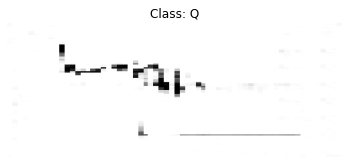

In [ ]:
generate_and_plot_ecg(x_test, y_test, 3299)

# Discussion

**Common problems of GANs**

1.   Vanishing Gradients
> Vanishing gradients usually caused during back propagation. It is happen when the gradients become very small by each iteration of training after partial derivatives. Then cause slow, and eventually stopped the weights update.

2.   Mode Collapse
> Mode collapse is a type of GAN failure where each iteration of the generator over-optimizes for a specific discriminator, leading to the discriminator being unable to learn and escape from this trap. Consequently, the generator ends up producing a limited range of output types, causing a rotation effect.

> However, I hope this will demonstrate my understanding of GANs architecture, and have a chance to learn and value your team. Thank you for consideration.

> With for time and resources, I hope this model a perform better results.

To see the project results and models, visit:

> https://github.com/tharathip-kulchotirat/bagan-for-ecg-synthesis

#### These are my past attempts to build a GAN model.

**Result History:**

> https://drive.google.com/drive/folders/1gAwMxm-cycxALHSjTxjHerMWMrl__WdX?usp=share_link



**Past Attempts:**



> https://colab.research.google.com/drive/1gVub4QeGRlDYI3PG_lNF-cU7WYnNzsUO


> https://colab.research.google.com/drive/143p32j3BoKMduBUF-KEJMOxg3rx8L2nz



> https://colab.research.google.com/drive/1YD1na-N8QNpAH-WNuZo3o-sc8VDlNCtO



> https://colab.research.google.com/drive/14_JJd4tO0FAc1OZ37ltAu4iWdSxHR_fK







